In [1]:
import pandas as pd
import numpy as np
import pyodbc
import warnings
warnings.filterwarnings("ignore")

In [71]:
# matplotlib 中文顯示問題
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [225]:
class ToolBox:
    def __init__(self, df):
        import pandas as pd
        import numpy as np
        import pyodbc #Sql-Connector
        
        self.__df = df.copy()
        self.__start = df.index[0]
        self.__end = df.index[-1]
    
    
    def getDataFromSql(self, MarketReturn=True, RiskFreeReturn=None):
        '''
        Connect Sql_database for TWA00 and RiskfreeRate
        '''
        strStartDate = str(self.__start)[:10].replace('-','')
        strEndDate = str(self.__end)[:10].replace('-','')
        
        DB_dt={'ip':'YourIP','db':'YourDatabase','user':'YourUsername','pwd':'YourPassword'}
        conn_DB_dt= pyodbc.connect('DRIVER={SQL Server};SERVER='+DB_dt['ip']+';DATABASE='+DB_dt['db']+';UID='+DB_dt['user']+';PWD='+DB_dt['pwd'])
        
        qrysql_MarketData=  f"SELECT 日期,股票代號,[漲幅(%)] \
                    FROM sysdbasere WHERE 股票代號 = 'TWA00'\
                    AND 日期 BETWEEN '{strStartDate}' AND '{strEndDate}' \
                    order by 股票代號,日期 asc"

        qrysql_RiskFreeData =  f" SELECT 年月, 數值 FROM sysallun WHERE 代號 = 'R001' \
                    AND 年月 BETWEEN '{strStartDate[:-2]}' AND '{strEndDate[:-2]}' \
                    ORDER BY 年月 ASC"
        
        if MarketReturn and RiskFreeReturn:
            return pd.read_sql(qrysql_MarketData,conn_DB_dt), pd.read_sql(qrysql_RiskFreeData,conn_DB_dt)
        
        if MarketReturn:
            return pd.read_sql(qrysql_MarketData,conn_DB_dt)
        
        
    @classmethod
    def getDataFromSqlcls(self, StartDate, EndDate, MarketReturn=True, RiskFreeReturn=None):
        strStartDate = str(StartDate)[:10].replace('-','')
        strEndDate = str(EndDate)[:10].replace('-','')
        
        DB_dt={'ip':'YourIP','db':'YourDatabase','user':'YourUsername','pwd':'YourPassword'}
        conn_DB_dt= pyodbc.connect('DRIVER={SQL Server};SERVER='+DB_dt['ip']+';DATABASE='+DB_dt['db']+';UID='+DB_dt['user']+';PWD='+DB_dt['pwd'])
        
        qrysql_MarketData=  f"SELECT 日期,股票代號,[漲幅(%)] \
                    FROM sysdbasere WHERE 股票代號 = 'TWA00'\
                    AND 日期 BETWEEN '{strStartDate}' AND '{strEndDate}' \
                    order by 股票代號,日期 asc"

        qrysql_RiskFreeData =  f" SELECT 年月, 數值 FROM sysallun WHERE 代號 = 'R001' \
                    AND 年月 BETWEEN '{strStartDate[:-2]}' AND '{strEndDate[:-2]}' \
                    ORDER BY 年月 ASC"
        
        if MarketReturn and RiskFreeReturn:
            return pd.read_sql(qrysql_MarketData,conn_DB_dt), pd.read_sql(qrysql_RiskFreeData,conn_DB_dt)
        
        if MarketReturn:
            return pd.read_sql(qrysql_MarketData,conn_DB_dt)
        
    
    @classmethod
    def convertYearly(self, cummulativeReturn, period):
        '''
        Convert input cummulativeReturn(%) to YearlyReturn(%)
        '''
        cummulativeReturn_Year = (1 + cummulativeReturn/100) ** (250/period) - 1
        return cummulativeReturn_Year*100
    
    
    @classmethod
    def calculateCummulativeReturn(self, portfolioReturn):
        '''
        Convert Series of Return(%) to Series of CummulativeReturn(%)
        '''
        portfolioReturn['cummulativeReturn'] = portfolioReturn.iloc[:,0] / 100 + 1
        portfolioReturn['cummulativeReturn'] = portfolioReturn['cummulativeReturn'].cumprod() - 1
        return portfolioReturn['cummulativeReturn']*100
    
    
    def calculateBetaAlpha(self):
        '''
        Calculate Beta, Alpha.
        Must fit the DataFrame first.
        '''
        #回歸分析模組(計算beta)----
        import statsmodels.formula.api as smf
        
        marketReturn, riskfreeReturn = self.getDataFromSql(MarketReturn=True, RiskFreeReturn=True)
        
        marketReturn.index = pd.to_datetime(marketReturn['日期'])
        
        RegressionData = pd.concat([self.__df,marketReturn], axis=1)
        RegressionData.rename(columns={'單日報酬(%)':'ret', '漲幅(%)':'MKTRET'}, inplace=True)
        mdl = smf.ols('ret ~ MKTRET', data=RegressionData).fit()
        beta = mdl.params[1]
        
        riskfreeReturn['年月'] = riskfreeReturn['年月'] + '01'
        riskfreeReturn.index = pd.to_datetime(riskfreeReturn['年月'])
        riskfreeReturn.rename(columns={'數值':'RF'}, inplace=True)
        
        cummulativePortfolioReturn = self.calculateCummulativeReturn(self.__df[['單日報酬(%)']])[-1]
        cummulativeMarketReturn = self.calculateCummulativeReturn(marketReturn[['漲幅(%)']])[-1]
        cummulativeRiskfreeReturn = self.calculateCummulativeReturn(riskfreeReturn[['RF']])[-1]
        marketPremium = cummulativeMarketReturn - cummulativeRiskfreeReturn
        
        alpha = cummulativePortfolioReturn - (cummulativeRiskfreeReturn + beta*marketPremium)
        
        return beta, alpha
    

class Backtest:
    def __init__(self, df, fee=0.001425, tax=0.003):
        import pandas as pd
        import numpy as np
        
        self.__df = df.copy()
        self.__fee = fee
        self.__tax = tax
    
    
    def __getHoldingCondition(self):
        def conditionTransformer(condition, hold_period):
            condition = list(condition)
            for i in range(len(condition)):
                if condition[i] == 1:
                    for j in range(1, hold_period):
                        if i+j < len(condition):
                            condition[i+j] = -1
            for i in range(len(condition)):
                if condition[i] == -1:
                    condition[i] = 1
            condition.pop()
            condition.insert(0,0)
            return condition
        hold = self.__df.groupby(by='code')['condition'].apply(conditionTransformer, self.__hold_period)
        return [condition for code in hold for condition in code]
    
    
    def __calculatePortfolioReturn(self):
        time = list(set(self.__df.index))
        time.sort()
        portfolio = self.__df.copy()
        portfolio['是否持有'] = self.__getHoldingCondition()
        portfolio = portfolio[portfolio['是否持有']==1]
        
        portfolioReturn = []
        portfolioNumbers = []
        buyNumbers = []
        sellNumbers = []
        lastdayStocks = portfolio[portfolio['是否持有']==2]['code'] #為了isin() 創造相同格式的空DataFrame
        
        for date in time:
            if date in portfolio.index:
                crossSectionProfolio = portfolio.loc[date]
                portfolioReturn.append(crossSectionProfolio['ret'].mean())
                portfolioNumbers.append(crossSectionProfolio['是否持有'].sum())
                
                buyNumbers.append(crossSectionProfolio[~crossSectionProfolio['code'].isin(lastdayStocks)].shape[0])
                sellNumbers.append(lastdayStocks[~lastdayStocks.isin(crossSectionProfolio['code'])].shape[0])
                lastdayStocks = crossSectionProfolio['code']
            else:
                portfolioReturn.append(0)
                portfolioNumbers.append(0)
                buyNumbers.append(0)
                sellNumbers.append(0)
        
        portfolioNumbers.pop(0)
        portfolioNumbers.append(portfolioNumbers[-1])
        buyNumbers.pop(0)
        buyNumbers.append(0)
        sellNumbers.pop(0)
        sellNumbers.append(portfolioNumbers[-1])
        
        dic = {'個股檔數':portfolioNumbers,'買進':buyNumbers, '賣出':sellNumbers, '單日報酬(%)':portfolioReturn}
        result = pd.DataFrame(dic, index=time)
        result['累計報酬(%)'] = ToolBox.calculateCummulativeReturn(result[['單日報酬(%)']])
        return result[['個股檔數','買進','賣出','單日報酬(%)','累計報酬(%)']]
    
    
    def __calculatePortfolioReturn_Taxed(self):
        portfolioReturn = self.__calculatePortfolioReturn()
        portfolioReturn['買進成本比重'] = portfolioReturn['買進'] / portfolioReturn['個股檔數']
        portfolioReturn['賣出成本比重'] = portfolioReturn['賣出'] / portfolioReturn['個股檔數']
        portfolioReturn['單日報酬(%)'] = (
                                            portfolioReturn['單日報酬(%)']/100 
                                            - self.__fee*portfolioReturn['買進成本比重']
                                            - (self.__fee+self.__tax)*portfolioReturn['賣出成本比重']
                                            )*100
        portfolioReturn['累計報酬(%)'] = ToolBox.calculateCummulativeReturn(portfolioReturn[['單日報酬(%)']])
        return portfolioReturn[['個股檔數','買進','賣出','單日報酬(%)','累計報酬(%)']]
        
        
    def __calculateStatistics(self, Tax):
        if Tax:
            data = self.__calculatePortfolioReturn_Taxed()
        else:
            data = self.__calculatePortfolioReturn()
            
        tool = ToolBox(data)
        cummulativeReturn = data['累計報酬(%)'][-1]
        cummulativeReturn_Year = ToolBox.convertYearly(cummulativeReturn, len(data))
        standard_deviation = data['單日報酬(%)'][1:].std()*np.sqrt(250)
        average_stocks = data['個股檔數'].mean()
        beta, alpha = tool.calculateBetaAlpha()

        return cummulativeReturn, cummulativeReturn_Year, standard_deviation, average_stocks, beta, alpha
    
    
    def __calculateMarketStatistics(self):
        MKTRET = ToolBox.getDataFromSqlcls(self.__df.index[0], self.__df.index[-1], MarketReturn=True)
        MKTRET.index = pd.to_datetime(MKTRET['日期'])
        MKTRET['累計報酬(%)'] = ToolBox.calculateCummulativeReturn(MKTRET[['漲幅(%)']])
        cummulativeReturn = MKTRET['累計報酬(%)'][-1]
        cummulativeReturn_Year = ToolBox.convertYearly(cummulativeReturn, len(MKTRET))
        standard_deviation = MKTRET['漲幅(%)'][1:].std()*np.sqrt(250)
        return cummulativeReturn, cummulativeReturn_Year, standard_deviation, 1, 1, 0
    
    
    def getPortfolioReturn(self, hold_period=5, Tax=True):
        '''
        hold_period: 一旦買入，持有hold_period日後，再決定是否繼續持有
        Tax: 是否計算手續費及稅率
        '''
        self.__hold_period = hold_period #只有重新呼叫才能更改hold_period
        
        if Tax:
            result = self.__calculatePortfolioReturn_Taxed().rename(columns={'單日報酬(%)':'課稅單日報酬(%)','累計報酬(%)':'課稅累計報酬(%)'})
            return result.apply(lambda x : np.round(x, 2))
        else:
            portfolioReturn = self.__calculatePortfolioReturn()
            return portfolioReturn.apply(lambda x : np.round(x, 2))
        
    
#     def getStatistics(self, hold_period=5, Tax=True):
#         self.__hold_period = hold_period
#         index = ['累計報酬(%)', '年化報酬(%)', '標準差', '平均持股', 'Beta', 'Alpha']
#         if Tax:
#             data = list(self.__calculateStatistics(Tax))
#             return pd.DataFrame(data, index=index, columns=['持有'+str(hold_period)+'日課稅']).T.apply(lambda x: np.round(x, 2))
#         else:
#             data = list(self.__calculateStatistics(Tax))
#             return pd.DataFrame(data, index=index, columns=['持有'+str(hold_period)+'日']).T.apply(lambda x: np.round(x, 2))
        
    
    def getStatistics(self, periods, Tax=True):
        index = ['累計報酬(%)', '年化報酬(%)', '標準差', '平均持股', 'Beta', 'Alpha']
        result = pd.DataFrame(index=index)
        result['大盤'] = self.__calculateMarketStatistics()
        if Tax:
            for period in periods:
                self.__hold_period = period
                result[str(period)+'日含稅'] = self.__calculateStatistics(Tax)
        else:
            for period in periods:
                self.__hold_period = period
                result[str(period)+'日'] = self.__calculateStatistics(Tax)
        return result.T.apply(lambda x: np.round(x,2))
        
    def plotResults(self, periods, show_difference=None):
        import matplotlib.pyplot as plt
        # matplotlib 中文顯示問題
        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
        plt.rcParams['axes.unicode_minus'] = False
        
        data = self.getPortfolioReturn()
        index = data.index
        tool = ToolBox(data)
        MKTRET = tool.getDataFromSql(MarketReturn=True)
        MKTRET['大盤累計報酬(%)'] = ToolBox.calculateCummulativeReturn(MKTRET[['漲幅(%)']])

        fig, ax = plt.subplots(figsize=(24,12))
        ax.plot(index, MKTRET['大盤累計報酬(%)'], label='TWA00', lw=3)
        
        if show_difference:
            for period in periods:
                ax.plot(index, backtest.getPortfolioReturn(hold_period=period)['課稅累計報酬(%)'], label=str(period)+'日含稅', lw=1.5)
                ax.plot(index, backtest.getPortfolioReturn(hold_period=period, Tax=False)['累計報酬(%)'], label=str(period)+'日', ls='--')    
        else:
            for period in periods:
                ax.plot(index, backtest.getPortfolioReturn(hold_period=period)['課稅累計報酬(%)'], label=str(period)+'日含稅', ls='--', lw=2)
        plt.title('Cummulative Return', fontsize=32)
        plt.legend(fontsize=20)
        plt.ylabel('Return(%)', fontsize=24)
        plt.xlabel('Time', fontsize=24)
            

# 1. Prepare Data

In [23]:
time = [20171130,20220801]

In [24]:
DB_dt={'ip':'YourIP','db':'YourDatabase','user':'YourUsername','pwd':'YourPassword'}
conn_DB_dt= pyodbc.connect('DRIVER={SQL Server};SERVER='+DB_dt['ip']+';DATABASE='+DB_dt['db']+';UID='+DB_dt['user']+';PWD='+DB_dt['pwd'])

# 日收盤
qrysql_dt=  f"SELECT 日期,股票代號,開盤價,最高價,最低價,收盤價,成交量,[漲幅(%)] \
            FROM sysdbasere WHERE 股票代號 IN (SELECT 股票代號 FROM syszine) \
            AND 日期 BETWEEN {time[0]} AND {time[1]} \
            order by 股票代號,日期 asc"

dt=pd.read_sql(qrysql_dt,conn_DB_dt)
dt.index = pd.to_datetime(dt['日期'])
stock_data = dt[['股票代號','開盤價','最高價','最低價','收盤價','成交量','漲幅(%)']].copy()
stock_data.rename(columns={'股票代號':'code','開盤價':'open','最高價':'high','最低價':'low','收盤價':'close','成交量':'volume','漲幅(%)':'ret'}, inplace=True)


# 外資
qrysql_dt=  f"SELECT 日期, 股票代號, 外資買賣超, [外資買賣超金額(千)] \
            FROM sysdfasion WHERE 股票代號 IN (SELECT 股票代號 FROM syszine) AND 日期 BETWEEN {time[0]} AND {time[1]} \
            ORDER BY 股票代號,日期 ASC"
            
dt=pd.read_sql(qrysql_dt,conn_DB_dt)
dt.index = pd.to_datetime(dt['日期'])
fr = dt[['股票代號','外資買賣超','外資買賣超金額(千)']].copy()
fr.rename(columns={'股票代號':'code','外資買賣超':'fnbs','外資買賣超金額(千)':'fnbs1000'}, inplace=True)

In [25]:
def data_filter(raw_data, slicing_time:list):
    
    data = raw_data.loc[slicing_time[0]:slicing_time[1]].copy()
    # 產出選股條件 

    data['cum5_fnbs1000'] = data['fnbs1000'].rolling(window=5).sum()
    dropping = np.sum(data['cum5_fnbs1000'].isna())
    data.dropna(inplace=True)

    date_index = set(data.index)
    date_index = list(date_index)
    date_index.sort()
    date_index = date_index[dropping:]
    
    data = data[data.index.isin(date_index)]

    condition = []
    for i in range(len(data)):
        if (data['fnbs'][i] > 1000) & (data['cum5_fnbs1000'][i] > 300000):
            condition.append(1)
        else:
            condition.append(0)

    data['condition'] = condition

    return data

In [26]:
stock_data

,code,open,high,low,close,volume,ret
日期,,,,,,,
2017-11-30,1101,19.23,19.26,19.03,19.03,26474,-1.03
2017-12-01,1101,19.23,19.23,19.03,19.12,7123,0.45
2017-12-04,1101,19.06,19.26,19.03,19.26,6593,0.74
2017-12-05,1101,19.23,19.26,19.06,19.26,9422,0.00
2017-12-06,1101,19.23,19.66,19.18,19.18,22611,-0.44
...,...,...,...,...,...,...,...
2022-07-26,9962,15.10,15.15,14.75,14.80,556,-1.99
2022-07-27,9962,14.85,15.10,14.80,15.10,320,2.03
2022-07-28,9962,15.15,15.25,14.95,14.95,343,-0.99


In [27]:
fr

,code,fnbs,fnbs1000
日期,,,
2017-11-30,1101,-4028.912,-135533
2017-12-01,1101,-2527.200,-85167
2017-12-04,1101,-2532.365,-85746
2017-12-05,1101,-3461.560,-116828
2017-12-06,1101,-12496.920,-426395
...,...,...,...
2022-07-26,9962,-57.000,-850
2022-07-27,9962,115.000,1722
2022-07-28,9962,-49.000,-737


In [28]:
raw_data = pd.concat([stock_data,fr],axis=1)
raw_data = raw_data.loc[:,~raw_data.columns.duplicated()]
raw_data

,code,open,high,low,close,volume,ret,fnbs,fnbs1000
日期,,,,,,,,,
2017-11-30,1101,19.23,19.26,19.03,19.03,26474,-1.03,-4028.912,-135533
2017-12-01,1101,19.23,19.23,19.03,19.12,7123,0.45,-2527.200,-85167
2017-12-04,1101,19.06,19.26,19.03,19.26,6593,0.74,-2532.365,-85746
2017-12-05,1101,19.23,19.26,19.06,19.26,9422,0.00,-3461.560,-116828
2017-12-06,1101,19.23,19.66,19.18,19.18,22611,-0.44,-12496.920,-426395
...,...,...,...,...,...,...,...,...,...
2022-07-26,9962,15.10,15.15,14.75,14.80,556,-1.99,-57.000,-850
2022-07-27,9962,14.85,15.10,14.80,15.10,320,2.03,115.000,1722
2022-07-28,9962,15.15,15.25,14.95,14.95,343,-0.99,-49.000,-737


In [29]:
slicing_time = ['20160801','20220801']

df = data_filter(raw_data, slicing_time)

### Prepared data 

In [30]:
df

,code,open,high,low,close,volume,ret,fnbs,fnbs1000,cum5_fnbs1000,condition
日期,,,,,,,,,,,
2017-12-06,1101,19.23,19.66,19.18,19.18,22611,-0.44,-12496.920,-426395,-849669.0,0
2017-12-07,1101,19.29,19.38,19.20,19.23,13793,0.30,-783.000,-26559,-740695.0,0
2017-12-08,1101,19.26,19.32,19.12,19.18,3200,-0.29,-1451.345,-49056,-704584.0,0
2017-12-11,1101,19.23,19.35,19.12,19.35,2431,0.89,-912.000,-30999,-649837.0,0
2017-12-12,1101,19.35,19.35,19.12,19.23,3099,-0.59,-1414.085,-47853,-580862.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-26,9962,15.10,15.15,14.75,14.80,556,-1.99,-57.000,-850,2147.0,0
2022-07-27,9962,14.85,15.10,14.80,15.10,320,2.03,115.000,1722,4699.0,0
2022-07-28,9962,15.15,15.25,14.95,14.95,343,-0.99,-49.000,-737,151.0,0


# 2. Backtest

### ※兩個方法互相獨立

### 1.getPortfolioReturn: 得到投組報酬

In [40]:
# 創造df 的實體物件 backtest
backtest = Backtest(df)

# Default: hold_period=5, Tax=True
backtest.getPortfolioReturn()

,個股檔數,買進,賣出,課稅單日報酬(%),課稅累計報酬(%)
2017-12-06,12,12,0,-0.14,-0.14
2017-12-07,15,3,0,0.67,0.53
2017-12-08,21,6,0,2.32,2.86
2017-12-11,23,2,0,1.54,4.44
2017-12-12,25,2,0,-0.65,3.76
...,...,...,...,...,...
2022-07-26,35,5,5,-0.90,-30.06
2022-07-27,31,1,5,0.91,-29.43
2022-07-28,23,0,8,-0.06,-29.47
2022-07-29,21,5,7,0.64,-29.02


#### 同筆資料，不同持有期間

In [44]:
backtest.getPortfolioReturn(hold_period=10)

,個股檔數,買進,賣出,課稅單日報酬(%),課稅累計報酬(%)
2017-12-06,12,12,0,-0.14,-0.14
2017-12-07,15,3,0,0.67,0.53
2017-12-08,21,6,0,2.32,2.86
2017-12-11,23,2,0,1.54,4.44
2017-12-12,25,2,0,-0.65,3.76
...,...,...,...,...,...
2022-07-26,46,4,2,-1.00,11.68
2022-07-27,45,1,2,0.77,12.54
2022-07-28,44,0,1,-0.29,12.21
2022-07-29,45,4,3,0.58,12.86


# 2. Result Statistics

In [198]:
# Default: Tax=True
backtest.getStatistics(periods=[5])

,累計報酬(%),年化報酬(%),標準差,平均持股,Beta,Alpha
大盤,41.88,8.01,16.90,1.00,1.00,0.00
5日含稅,-29.40,-7.38,22.08,28.53,1.07,-71.86


#### 同筆資料，不同持有期間

In [204]:
periods=[5,10,20,60]

In [205]:
result_df_tax = backtest.getStatistics(periods=periods)
result_df_tax

,累計報酬(%),年化報酬(%),標準差,平均持股,Beta,Alpha
大盤,41.88,8.01,16.90,1.00,1.00,0.00
5日含稅,-29.40,-7.38,22.08,28.53,1.07,-71.86
10日含稅,12.44,2.62,21.72,42.23,1.09,-30.20
20日含稅,34.46,6.74,21.48,62.44,1.11,-8.35
60日含稅,61.97,11.21,21.11,105.11,1.11,19.11


#### Tax=False 不計算手續費、證交稅 

In [206]:
result_df = backtest.getStatistics(periods=periods,Tax=False)
result_df

,累計報酬(%),年化報酬(%),標準差,平均持股,Beta,Alpha
大盤,41.88,8.01,16.90,1.00,1.00,0.00
5日,116.65,18.56,21.98,28.53,1.06,74.23
10日,104.98,17.13,21.69,42.23,1.08,62.35
20日,83.29,14.28,21.48,62.44,1.11,40.48
60日,80.49,13.89,21.10,105.11,1.11,37.64


#### 手動合併 

In [220]:
concat_df = pd.concat([result_df, result_df_tax])
concat_df = concat_df[~concat_df.index.duplicated()]
concat_df

,累計報酬(%),年化報酬(%),標準差,平均持股,Beta,Alpha
大盤,41.88,8.01,16.90,1.00,1.00,0.00
5日,116.65,18.56,21.98,28.53,1.06,74.23
10日,104.98,17.13,21.69,42.23,1.08,62.35
20日,83.29,14.28,21.48,62.44,1.11,40.48
60日,80.49,13.89,21.10,105.11,1.11,37.64
5日含稅,-29.40,-7.38,22.08,28.53,1.07,-71.86
10日含稅,12.44,2.62,21.72,42.23,1.09,-30.20
20日含稅,34.46,6.74,21.48,62.44,1.11,-8.35
60日含稅,61.97,11.21,21.11,105.11,1.11,19.11


<AxesSubplot:xlabel='標準差', ylabel='年化報酬(%)'>

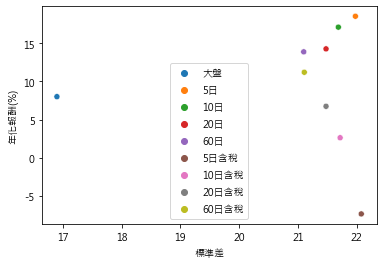

In [224]:
import seaborn as sns
sns.scatterplot(data=concat_df, x='標準差', y='年化報酬(%)', hue=concat_df.index)

# 3. Result Visualization

In [53]:
tool = ToolBox(df)

In [56]:
# 大盤報酬
MKTRET = tool.getDataFromSql(MarketReturn=True)
MKTRET

,日期,股票代號,漲幅(%)
0,20171206,TWA00,-1.64
1,20171207,TWA00,-0.37
2,20171208,TWA00,0.41
3,20171211,TWA00,0.72
4,20171212,TWA00,-0.28
...,...,...,...
1130,20220726,TWA00,-0.87
1131,20220727,TWA00,0.78
1132,20220728,TWA00,-0.20
1133,20220729,TWA00,0.73


In [63]:
# ToolBox類別可以直接呼叫累計報酬方法
MKTRET['大盤累計報酬(%)'] = ToolBox.calculateCummulativeReturn(MKTRET[['漲幅(%)']])
MKTRET

,日期,股票代號,漲幅(%),大盤累積報酬(%),大盤累計報酬(%)
0,20171206,TWA00,-1.64,-1.640000,-1.640000
1,20171207,TWA00,-0.37,-2.003932,-2.003932
2,20171208,TWA00,0.41,-1.602148,-1.602148
3,20171211,TWA00,0.72,-0.893684,-0.893684
4,20171212,TWA00,-0.28,-1.171181,-1.171181
...,...,...,...,...,...
1130,20220726,TWA00,-0.87,40.206579,40.206579
1131,20220727,TWA00,0.78,41.300191,41.300191
1132,20220728,TWA00,-0.20,41.017590,41.017590
1133,20220729,TWA00,0.73,42.047019,42.047019


In [64]:
periods = [5,10,20,60]

Text(0.5, 0, 'Time')

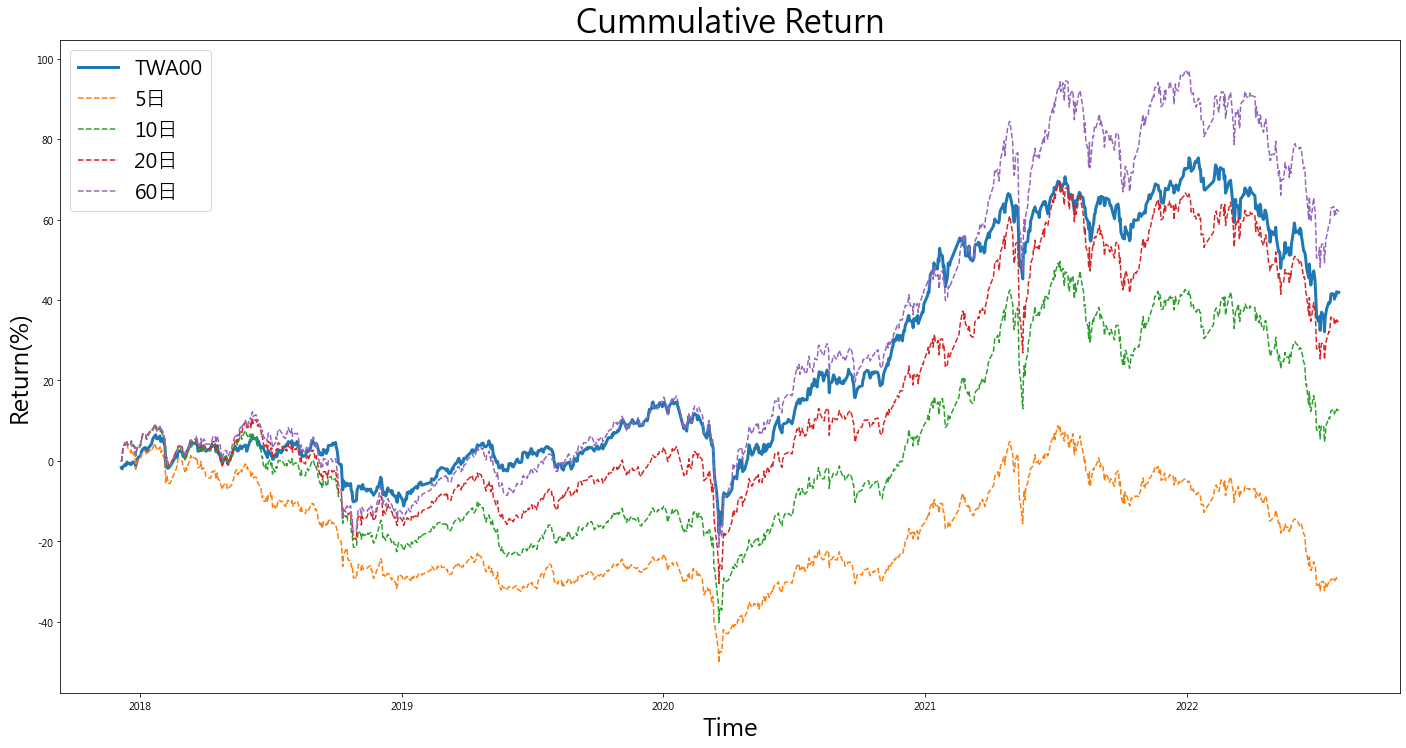

In [70]:
import matplotlib.pyplot as plt
index = backtest.getPortfolioReturn().index

fig, ax = plt.subplots(figsize=(24,12))

ax.plot(index, MKTRET['大盤累計報酬(%)'], label='TWA00', lw=3)
for period in periods:
    ax.plot(index, backtest.getPortfolioReturn(hold_period=period)['課稅累計報酬(%)'], label=str(period)+'日', ls="--")

plt.title('Cummulative Return', fontsize=32)
plt.legend(fontsize=20)
plt.ylabel('Return(%)', fontsize=24)
plt.xlabel('Time', fontsize=24)

### Class method 

In [226]:
backtest = Backtest(df)

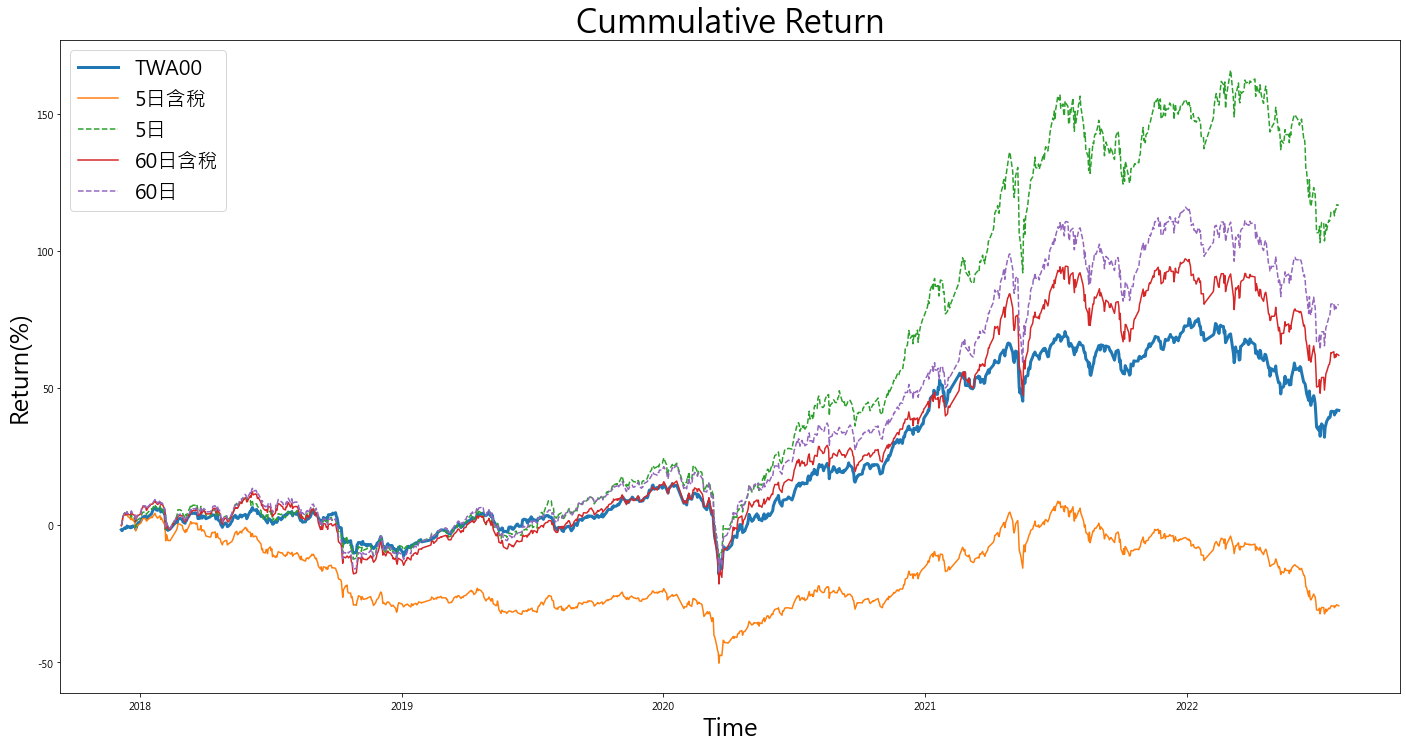

In [227]:
backtest.plotResults(periods=[5,60], show_difference=True)